# Análisis de StockerBot

## Carga de librerías necesarias para todo el proyecto/entregable

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pysentimiento import create_analyzer
from pysentimiento.preprocessing import preprocess_tweet
import nltk
import regex as re
import string
from nltk.stem import RegexpStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from textblob import TextBlob
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from yellowbrick.text import umap, UMAPVisualizer
from wordcloud import WordCloud
from collections import defaultdict, Counter
import wordtree
from tqdm import tqdm


## Carga de archivo CSV de StockerBot

In [2]:
stockerbot = pd.read_csv('datasets/stockerbot-export.csv', on_bad_lines='skip') 
stockerbot.head()

,id,text,timestamp,source,symbols,company_names,url,verified
0,1019696670777503700,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,True
1,1019709091038548000,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,True
2,1019711413798035500,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True
3,1019716662587740200,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,True
4,1019718460287389700,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True


## Preprocesamiento de información

### Limpieza del DataFrame

Se hace una selección de variables para poder manejar la información de una forma más amigable

In [3]:
stockerbot = stockerbot.drop(['url', 'id', 'symbols', 'verified', 'timestamp', 'company_names', 'source'], axis=1)
stockerbot.head()

,text
0,VIDEO: “I was in my office. I was minding my o...
1,The price of lumber $LB_F is down 22% since hi...
2,Who says the American Dream is dead? https://t...
3,Barry Silbert is extremely optimistic on bitco...
4,How satellites avoid attacks and space junk wh...


Se hace una revisión para revisar la longitud de datos, si hay datos con errores y/o vacíos y si hay datos duplicados

In [4]:
print('Total data: ', stockerbot.text.count())
print('Total with errors: ', stockerbot.text.isna().sum())
print('Total empty: ', stockerbot.text.isnull().sum())
print('Total duplicated entries: ', stockerbot.duplicated().sum())

Total data:  28264
Total with errors:  0
Total empty:  0
Total duplicated entries:  2579


Se eliminan los datos duplicados y se inserta una nueva columna 'ID' para referencia futura

In [5]:
stockerbot = stockerbot.drop_duplicates()
print('Total data: ', stockerbot.text.count())
print('Total with errors: ', stockerbot.text.isna().sum())
print('Total empty: ', stockerbot.text.isnull().sum())
print('Total duplicated entries: ', stockerbot.duplicated().sum())

Total data:  25685
Total with errors:  0
Total empty:  0
Total duplicated entries:  0


### Visualización de frecuencias

Número de caracteres por oración en columna 'text'

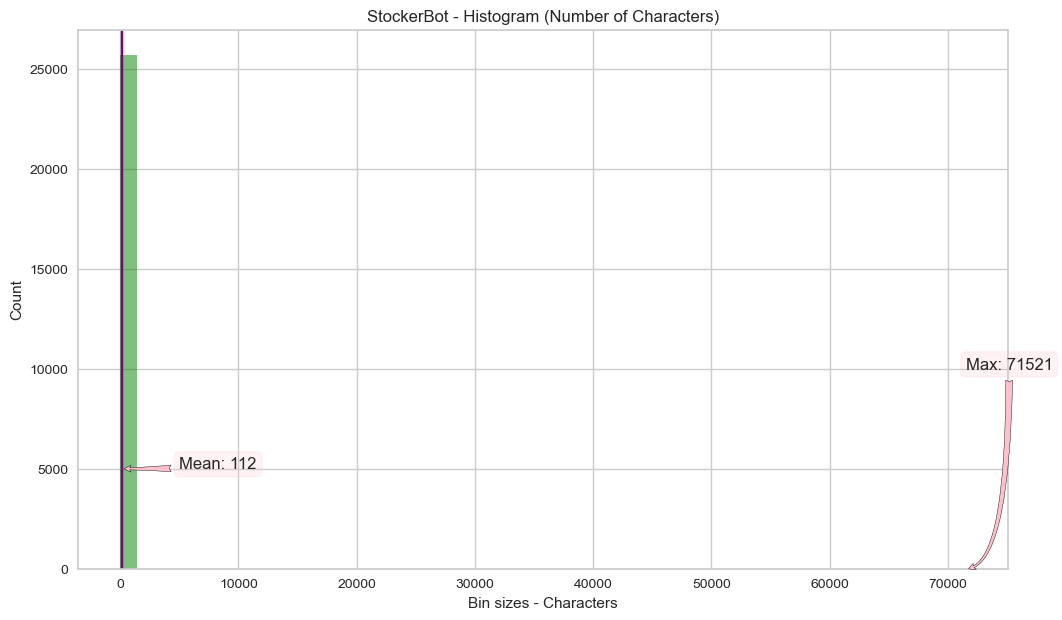

In [6]:
fig, ax = plt.subplots(figsize=(12,7))
ax = stockerbot.text.str.len().plot.hist(bins=50, alpha=0.5, color='green')
plt.axvline(x=stockerbot.text.str.len().mean(), ymin=0 , ymax=1, color='purple')
text_mean = 'Mean: %d' % stockerbot.text.str.len().mean()
text_max = 'Max: %d' % stockerbot.text.str.len().max()
bbox = dict(boxstyle='Round', color='pink', alpha=0.2, linewidth=0.9)
arrowprops = dict(facecolor='pink', arrowstyle='fancy', connectionstyle='angle3')
plt.annotate(text=text_mean, xy=(stockerbot.text.str.len().mean(), 5000), xytext=(5000, 5000), arrowprops=arrowprops, bbox=bbox)
plt.annotate(text=text_max, xy=(stockerbot.text.str.len().max(), 1), xytext=(stockerbot.text.str.len().max(), 10000), arrowprops=arrowprops, bbox=bbox)
plt.title('StockerBot - Histogram (Number of Characters)')
plt.xlabel('Bin sizes - Characters')
plt.ylabel('Count')
plt.show()

Se observa que los textos tienen una media de 112 caracteres y un máximo de 71521

Número de palabras por oración

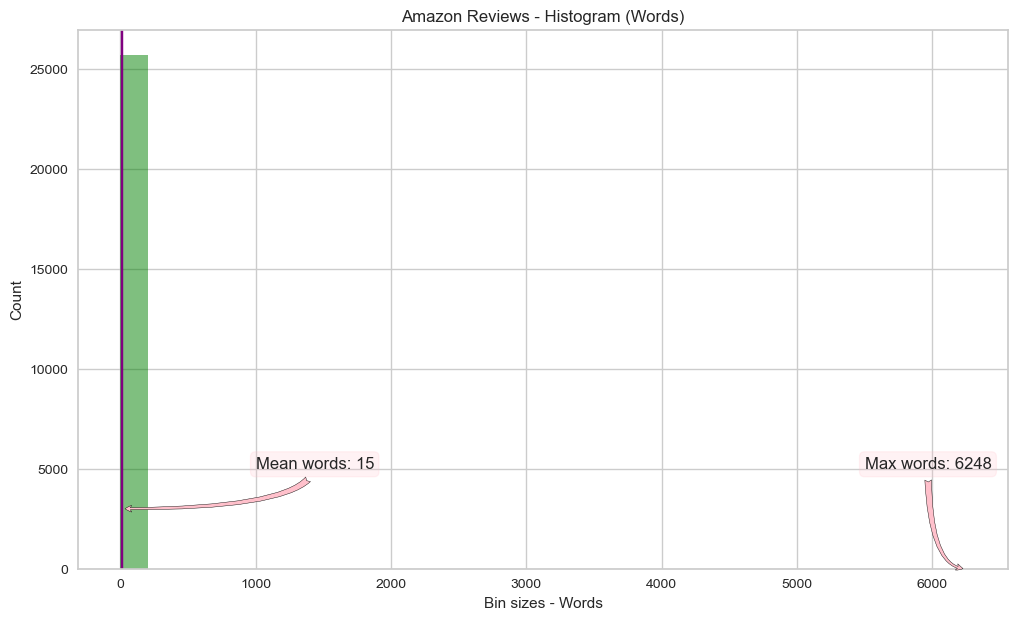

In [7]:
fig, ax = plt.subplots(figsize=(12,7))
ax = stockerbot.text.str.split().apply(lambda w: len(w)).plot.hist(bins=30, alpha=0.5, color='green')
text_mean = 'Mean words: %d' % stockerbot.text.str.split().apply(lambda w: len(w)).mean()
text_max = 'Max words: %d' % stockerbot.text.str.split().apply(lambda w: len(w)).max()
plt.axvline(x=stockerbot.text.str.split().apply(lambda w: len(w)).mean(), ymin=0, ymax=1, color='purple')
plt.annotate(text=text_mean, xy=(stockerbot.text.str.split().apply(lambda w: len(w)).mean(), 3000), xytext=(1000, 5000), arrowprops=arrowprops, bbox=bbox)
plt.annotate(text=text_max, xy=(stockerbot.text.str.split().apply(lambda w: len(w)).max(), 1), xytext=(5500, 5000), arrowprops=arrowprops, bbox=bbox)
plt.title('Amazon Reviews - Histogram (Words)')
plt.xlabel('Bin sizes - Words')
plt.ylabel('Count')
plt.show()

Se observa un máximo de 6248 palabras y una media de 15 palabras en los textos del dataframe

Se realizará un análisis para determinar el tamaño (longitud) de cada palabra dentro de cada review

In [8]:
a = round(stockerbot.text.str.split().apply(lambda word: [len(w) for w in word]).map(lambda w: np.mean(w)).mean(), 0)
b = round(stockerbot.text.str.split().apply(lambda word: [len(w) for w in word]).map(lambda w: np.mean(w)).max(), 0)
print (a, b)

7.0 30.0


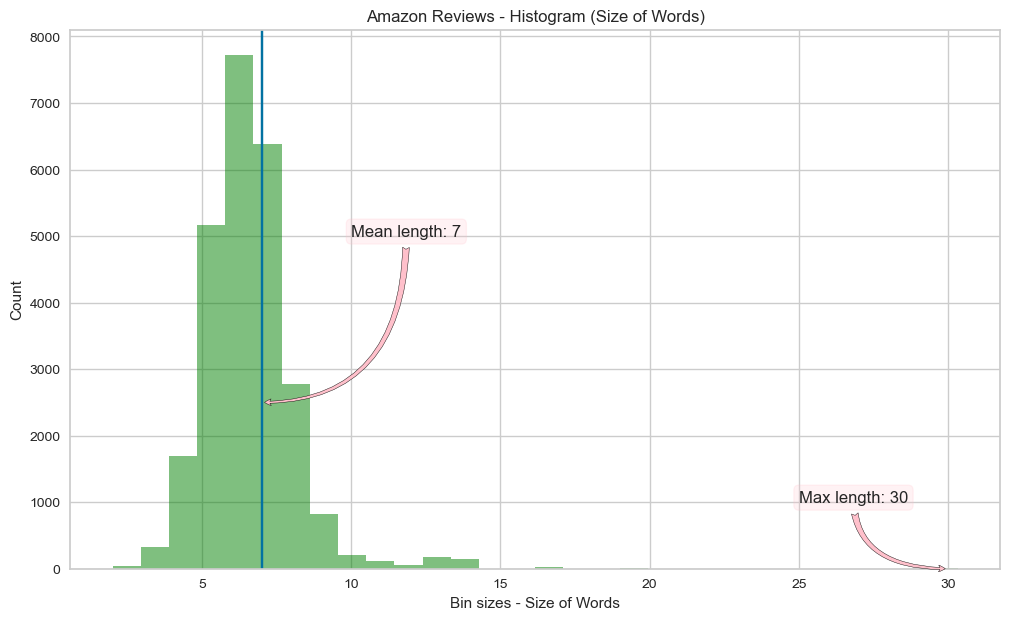

In [9]:
fig, ax = plt.subplots(figsize=(12,7))
ax = stockerbot.text.str.split().apply(lambda word: [len(w) for w in word]).map(lambda w: np.mean(w)).plot.hist(bins=30, alpha=0.5, color='green')
text_mean = 'Mean length: %d' % int(a)
text_max = 'Max length: %d' % int(b)
plt.axvline(x=a, ymin=0, ymax=1)
plt.annotate(text=text_mean, xy=(a, 2500), xytext=(10, 5000), arrowprops=arrowprops, bbox=bbox)
plt.annotate(text=text_max, xy=(b, 1), xytext=(25, 1000), arrowprops=arrowprops, bbox=bbox)
plt.title('Amazon Reviews - Histogram (Size of Words)')
plt.xlabel('Bin sizes - Size of Words')
plt.ylabel('Count')
plt.show()

Se observa una media de 7 caracteres por palabra y un máximo de 30. Esto indica que la dicción puede que sea correcta en cada oración.

Previo a iniciar con el análisis de sentimiento, se revisarán cuantos registros existen en diferentes intervalos de caracteres para decidir si se hace una eliminación de registros

In [10]:
a = len(stockerbot.where(stockerbot.text.str.len()>500).dropna())
b = len(stockerbot.where(stockerbot.text.str.len()>400).dropna()) - a
c = len(stockerbot.where(stockerbot.text.str.len()>300).dropna()) - (a+b)
d = len(stockerbot.where(stockerbot.text.str.len()>200).dropna()) - (a+b+c)
e = len(stockerbot.where(stockerbot.text.str.len()>100).dropna()) - (a+b+c+d)
f = len(stockerbot.where(stockerbot.text.str.len()<100).dropna())



print('Total reviews with less than 100 characters %d' % f)
print('Total reviews with more than 100 characters %d' % e)
print('Total reviews with more than 200 characters %d' % d)
print('Total reviews with more than 300 characters %d' % c)
print('Total reviews with more than 400 characters %d' % b)
print('Total reviews with more than 500 characters %d' % a)


Total reviews with less than 100 characters 10542
Total reviews with more than 100 characters 14884
Total reviews with more than 200 characters 0
Total reviews with more than 300 characters 0
Total reviews with more than 400 characters 0
Total reviews with more than 500 characters 6


Para facilitiar el procesamiento de los datos, se considerarán solamente los reviews que contengan hasta 150 caracteres.

In [11]:
stockerbot = stockerbot.where(stockerbot.text.str.len()<151).dropna()
stockerbot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25588 entries, 0 to 28263
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25588 non-null  object
dtypes: object(1)
memory usage: 399.8+ KB


In [12]:
stockerbot.head()

,text
0,VIDEO: “I was in my office. I was minding my o...
1,The price of lumber $LB_F is down 22% since hi...
2,Who says the American Dream is dead? https://t...
3,Barry Silbert is extremely optimistic on bitco...
4,How satellites avoid attacks and space junk wh...


## Revisión de palabras más frecuentes

Se crea una función para crear un corpus, dentro del cual se incluye la tokenización del texto, la limpieza de datos (incluyendo la eliminación de datos numéricos) y una función de stem para cortar palabras

In [13]:
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def remove_stopword(words):
    stop_words_en = set(stopwords.words('english'))
    stop_words_en.update([ 'would', 'RT', 'rt', 'inc', '@usuario', 'usuario', 'amp',
                        'really', "'s", "n't", 'www', 'emoji'
                        'url', 'com', "'t", 'http', 'https'])

    stop_words_es = stopwords.words('spanish')
    stop_words_es.extend(['RT', 'rt', 'inc', '@usuario', 'usuario', 'amp', 'emoji', 'url'])

    stop_words_en.update(stop_words_es)
    return [w for w in words if w.lower() not in stop_words_en]

Se realizará una limpieza de los datos, removiendo cadenas que contengan las palabras 'http(s)', 'RT' y @

In [14]:
stockerbot.text = stockerbot.text.astype(str).str.lower()
text = stockerbot.text.tolist()

new_text = []
for t in tqdm(text, colour='green', unit_scale=True):
    clear = preprocess_tweet(t)
    
    new_text.append(clear)


print(new_text[0:60])

100%|██████████| 25.6k/25.6k [00:00<00:00, 38.3kit/s]

['video: "i was in my office. i was minding my own business..." david solomon tells $gs interns how he learned he wa url', "the price of lumber $lb_f is down 22% since hitting its ytd highs. the macy's $m turnaround is still happening. url", 'who says the american dream is dead? url', 'barry silbert is extremely optimistic on bitcoin -- but predicts that 99% of new crypto entrants are "going to zero url', 'how satellites avoid attacks and space junk while circling the earth url paid @usuario url', ".@usuario's david butler's favorite fang stock isn't realmoneysod alphabet but facebook url", 'dont miss my convo with one of my favorite thinkers @usuario! url', 'u.s. intelligence documents on nelson mandela made public url url', 'senate wants emergency alerts to go out through netflix spotify etc. url by @usuario', 'hedge fund manager marc larsy says bitcoin $40k is possible url', 'u.s. proposes expedited appeal in fight with at&amp;t over time warner purchase url url', "roger federer's u

In [15]:
def create_corpus(text):
    
    stemmer = RegexpStemmer('ing$|s$', min=4)

    all_words = []

    stop_words_en = set(stopwords.words('english'))
    stop_words_en.update([ 'would', 'RT', 'rt', 'inc', '@usuario', 'usuario', 'amp',
                        'really', "'s", "n't", 'www', 'emoji'
                        'url', 'com', "'t", 'http', 'https'])

    stop_words_es = stopwords.words('spanish')
    stop_words_es.extend(['RT', 'rt', 'inc', '@usuario', 'usuario', 'amp', 'emoji', 'url'])

    stop_words_en.update(stop_words_es)

    for review in tqdm(text, total=len(text), colour='green', unit_scale=True):
        if review.isascii() == True:
            words = tokenize(review)
            all_words.append(words)
        else:
            all_words.append(review)
            all_words.remove(review)

    undo_lists = [val for sublist in all_words for val in sublist]
    clean = [w for w in undo_lists if w not in stop_words_en]
    clean_numeric = [word for word in clean if word.isalpha()]
    final = [stemmer.stem(w) for w in clean_numeric]

    return final

In [16]:
corpus = create_corpus(new_text)
print('Length: ', len(corpus))
print(corpus[0:20])

100%|██████████| 25.6k/25.6k [00:00<00:00, 68.1kit/s]

Length:  237442
['video', 'office', 'mind', 'busines', 'david', 'solomon', 'tell', 'gs', 'intern', 'learned', 'wa', 'price', 'lumber', 'since', 'hitt', 'ytd', 'high', 'macy', 'turnaround', 'still']


In [17]:
def word_counter_en(corpus, min_frequencies):
    count_words = Counter(corpus)
    
    frequencies_df = pd.DataFrame(
        count_words.most_common(), 
        columns=['Words', 'Frequencies']
        )
    
    frequencies_df = frequencies_df.query('Frequencies >= @min_frequencies')
    frequencies_df.set_index('Words', inplace=True)
    frequencies_df.sort_values('Frequencies', ascending=False)
    return frequencies_df

Se utiliza la función para generar un nuevo dataframe con la frecuencia de palabras en 50000 para evitar palabras con muy baja frecuencia. Se muestran solo las 20 primeras

In [18]:
frequencies = word_counter_en(corpus, 10)
plot_px = frequencies.head(20)
plot_px.head(20)

,Frequencies
Words,
stock,2471
analyst,1801
hacia,1692
flecha,1677
derecha,1647
price,1616
share,1566
earning,1539
new,1363


Se muestran las 20 últimas

In [19]:
plot_tail = frequencies.tail(20)
plot_tail.head(20)

,Frequencies
Words,
correct,10
dover,10
prelim,10
ffo,10
cpc,10
daytrader,10
chat,10
gasoline,10
southwestern,10


Se realiza una gráfica con las 20 palabras de mayor frecuencia

In [20]:
fig = px.bar(
    plot_px,
    x=plot_px.index, 
    y='Frequencies', 
    text_auto='.3s', 
    title='Top 20 Words Frequency', 
    color='Frequencies', 
    color_continuous_scale='Agsunset')
fig.show()

Se grafican las 20 más bajas (considerando un mínimo de 20000 frecuencias)

In [21]:
fig = px.bar(
    plot_tail,
    x=plot_tail.index, 
    y='Frequencies', 
    text_auto='.3s', 
    title='Tail 20 Words Frequency', 
    color='Frequencies', 
    color_continuous_scale='Cividis')
fig.update_traces(textfont_size=12, textangle=0, textposition='outside', cliponaxis=False)
fig.show()

## WordCloud

Se realiza una gráfica de nube de palabras con el Top 100 de palabras conforme al conteo realizado

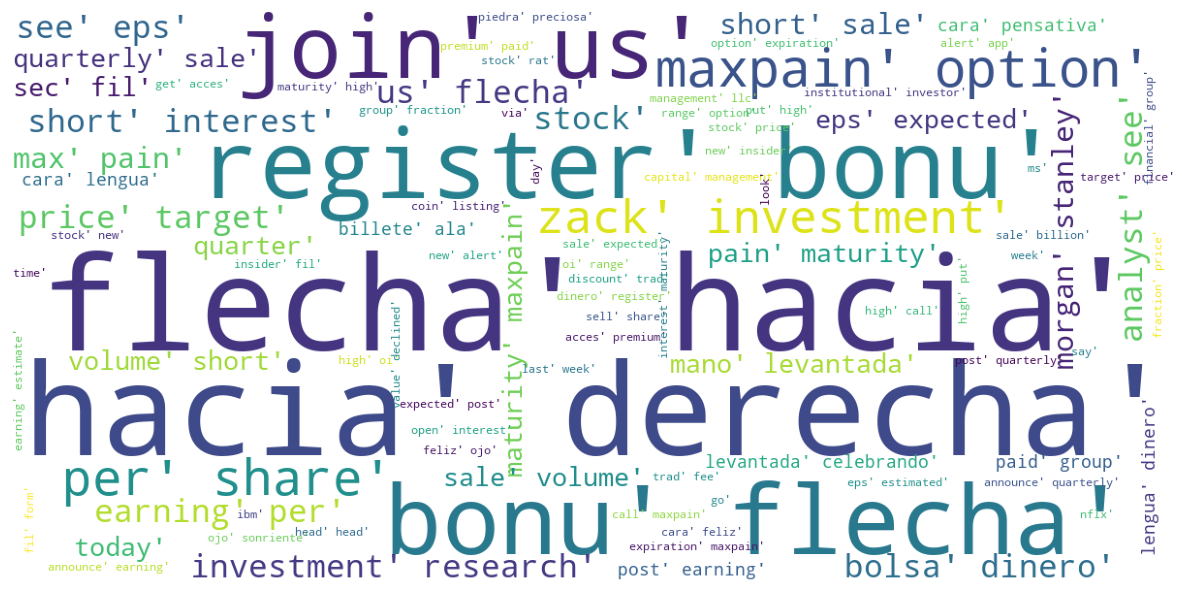

In [22]:
def wordclouds(corpus, color):
    stop_words = set(stopwords.words('english'))
    wordcloud = WordCloud(
        background_color=color,
        stopwords=stop_words,
        max_words=100,
        scale=3,
        
    )
    
    wordcloud = wordcloud.generate(str(corpus))
    fig = plt.figure(1, figsize=(15,15))
    plt.imshow(wordcloud)
    plt.axis('off')

    return plt.show()


wordclouds(corpus, '#ffffff')



## WordTree

Se realiza un WordTree con la palabra más frecuente obtenida del conteo de palabras

  0%|          | 0/25588 [00:00<?, ?it/s]

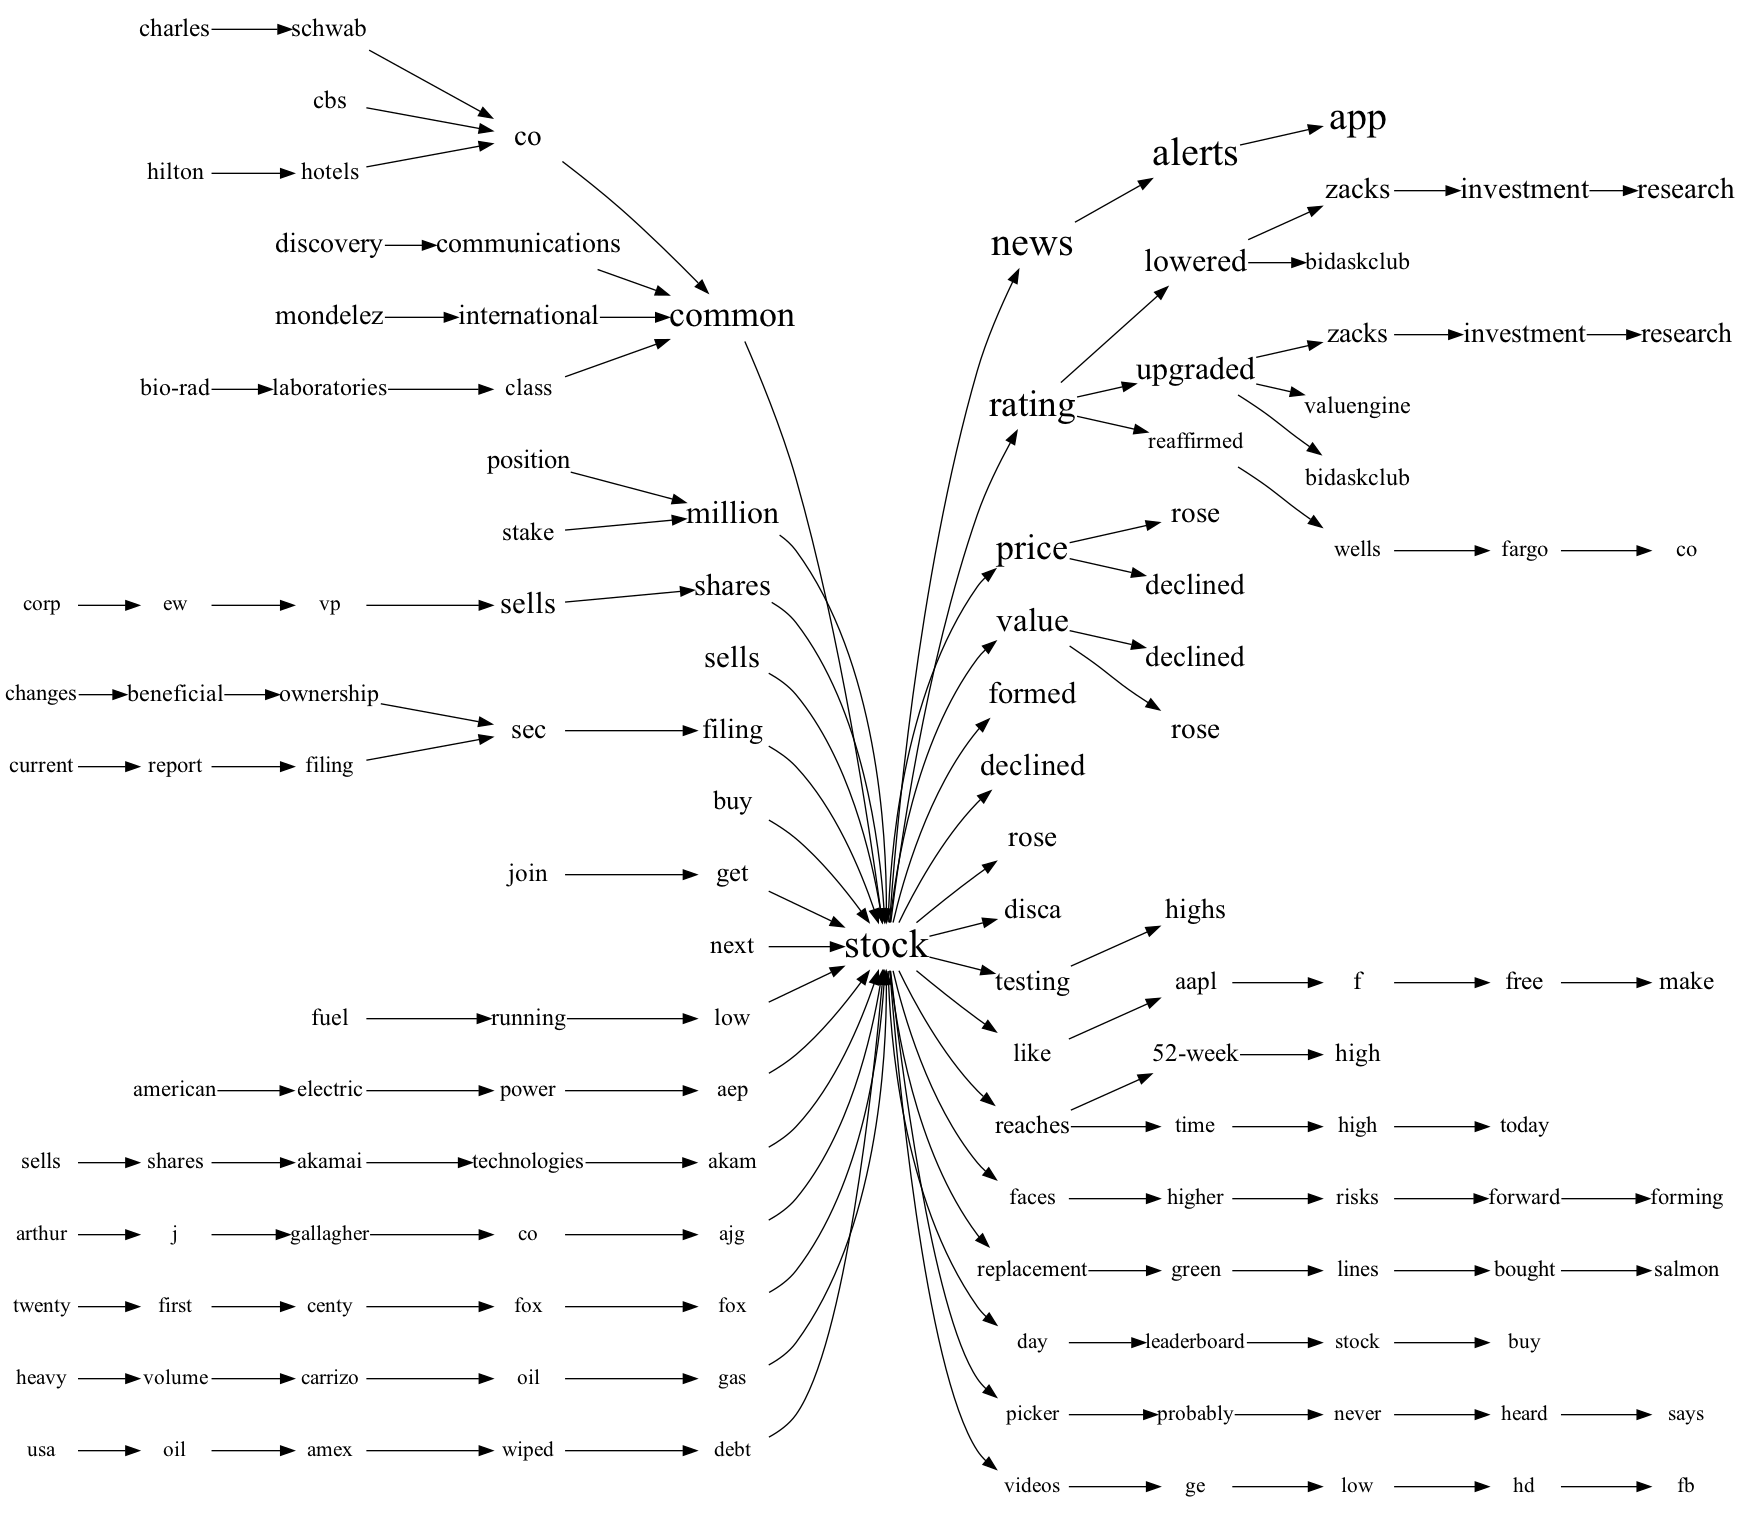

In [23]:
from PIL import Image

dataset = [remove_stopword(tokenize(word)) for word in new_text]
dataset = [' '.join(word) for word in dataset]
dataset = [x.lower() for x in dataset]
g = wordtree.search_and_draw(corpus=dataset, keyword='stock', max_n=6)
g.render()
Image.open('stock.gv.png')

## t-SNE

Se valida nuevamente que el dataset siga con los datos correctos

In [24]:
print(dataset[0:10])

['video office minding business david solomon tells gs interns learned wa', 'price lumber lb_f since hitting ytd highs macy turnaround still happening', 'says american dream dead', 'barry silbert extremely optimistic bitcoin predicts new crypto entrants going zero', 'satellites avoid attacks space junk circling earth paid', 'david butler favorite fang stock realmoneysod alphabet facebook', 'dont miss convo one favorite thinkers', 'u intelligence documents nelson mandela made public', 'senate wants emergency alerts go netflix spotify etc', 'hedge fund manager marc larsy says bitcoin 40k possible']


Se realiza la vectorizacióncon Word2Vec

In [25]:
from gensim.models.word2vec import Word2Vec
for w in tqdm(dataset, colour='magenta', unit_scale=True):
    dataset = tokenize(w)

dataset = [dataset] # Word2Vec reconoce una lista de listas, por eso se convierte el dataset a una lista nesteada
word2vec = Word2Vec(dataset, vector_size=100, window=5, min_count=0, epochs=10)
print(word2vec)

100%|██████████| 25.6k/25.6k [00:00<00:00, 150kit/s]

Word2Vec<vocab=15, vector_size=100, alpha=0.025>


Se revisa el vocabulario obtenido por Word2Vec

In [26]:
word2vec.wv.key_to_index

{'derecha': 0,
 'hacia': 1,
 'flecha': 2,
 'dinero': 3,
 'bolsa': 4,
 'alas': 5,
 'billete': 6,
 'time': 7,
 'limited': 8,
 'open': 9,
 'registration': 10,
 'binance': 11,
 'price': 12,
 'xlm': 13,
 'stellar': 14}

In [27]:
word2vec.wv.most_similar('binance', topn=10)

[('flecha', 0.17283736169338226),
 ('alas', 0.16693277657032013),
 ('time', 0.11131986975669861),
 ('registration', 0.10963228344917297),
 ('derecha', 0.07964599132537842),
 ('dinero', 0.04148717597126961),
 ('limited', 0.03787835314869881),
 ('hacia', 0.008315117098391056),
 ('bolsa', -0.005853768903762102),
 ('price', -0.030077114701271057)]

Se realiza la gráfica de t-SNE (n-grams)

[t-SNE] Computing 14 nearest neighbors...
[t-SNE] Indexed 15 samples in 0.000s...
[t-SNE] Computed neighbors for 15 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 15 / 15
[t-SNE] Mean sigma: 1.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.844090
[t-SNE] KL divergence after 63900 iterations: 0.323561


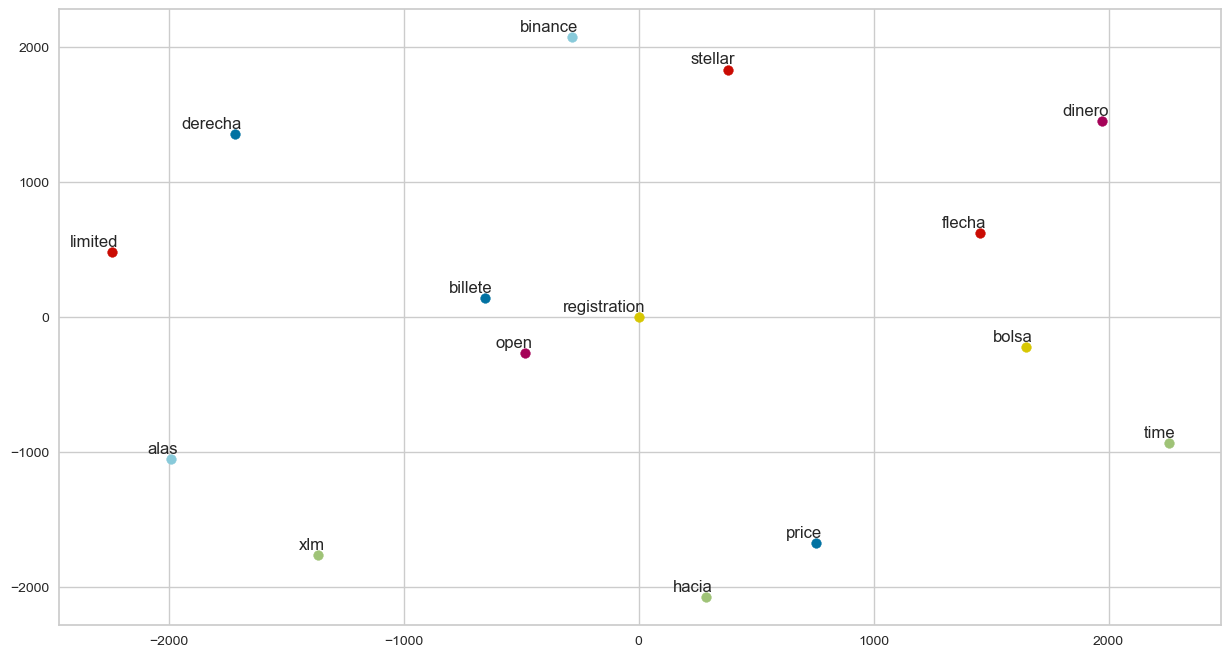

In [28]:
def vis_tsne_full(model, perplexity, dimensions, iter):
    tags = []
    tokens = np.empty([0, 100], dtype='f')

    for w in word2vec.wv.key_to_index:
        vector = word2vec.wv[w]
        tokens = np.append(tokens, np.array([vector]), axis=0)
        tags.append(w)

    tsne_model = TSNE(perplexity=perplexity, init='pca', n_components=dimensions, n_iter=iter, verbose=1)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []

    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(15, 8))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(tags[i], xy=(x[i],y[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

    return plt.show()

vis_tsne_full(word2vec, 14, 3, 200000)

Como se observa en el gráfico, dada las pocas repeticiones de muchas palabras, el vocabulario obtenido por Word2Vec es muy poco, por lo que al hacer la gráfica de t-SNE las palabras aparecen muy alejadas de si mismas.

## UMAP

In [29]:
dataset_umap = [remove_stopword(tokenize(word)) for word in new_text]
dataset_umap = [' '.join(word) for word in dataset_umap]
dataset_umap = [x.lower() for x in dataset_umap]

In [30]:
vectorizer = TfidfVectorizer(use_idf=True)

tfidf = vectorizer.fit_transform(dataset_umap)
df_tfidf = pd.DataFrame(
    tfidf[0].T.todense(), 
    index=vectorizer.get_feature_names_out(), 
    columns=['tf-idf']
    )

df_tfidf = df_tfidf.sort_values('tf-idf', ascending=False)
df_tfidf.head(25)

,tf-idf
solomon,0.364869
interns,0.364869
minding,0.364869
learned,0.350721
wa,0.308710
tells,0.302349
david,0.270376
office,0.253257
business,0.243939
video,0.229791


In [31]:
clusters = KMeans(n_clusters=5, n_init='auto', verbose=1)
clusters.fit(tfidf)

Initialization complete
Iteration 0, inertia 48971.36063237499.
Iteration 1, inertia 24942.986806726243.
Iteration 2, inertia 24846.317448315625.
Iteration 3, inertia 24832.44624952259.
Iteration 4, inertia 24828.50832292149.
Iteration 5, inertia 24824.873042801977.
Iteration 6, inertia 24822.221274647163.
Iteration 7, inertia 24821.078935670244.
Iteration 8, inertia 24820.45706971255.
Iteration 9, inertia 24819.71348437761.
Iteration 10, inertia 24819.045129793292.
Iteration 11, inertia 24818.93976436199.
Iteration 12, inertia 24818.932239360664.
Iteration 13, inertia 24818.931477195223.
Converged at iteration 13: strict convergence.


KMeans(n_clusters=5, n_init='auto', verbose=1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

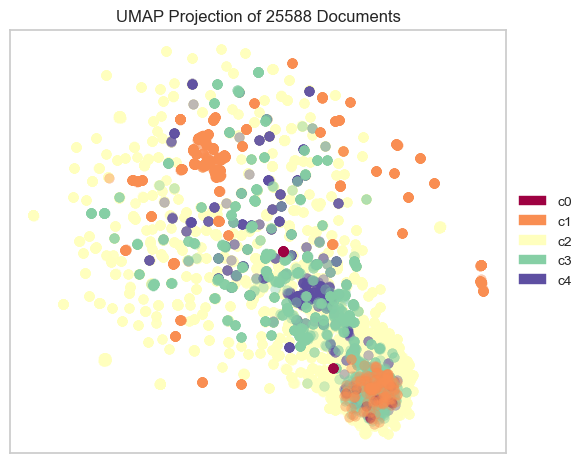

In [32]:
visualiser = umap(tfidf, ['c{}'.format(c) for c in clusters.labels_], alpha=0.4, colormap='Spectral')

Como se observa en la gráfica, muchos de los datos están muy alejados al agrupar los datos en cinco grupos. Esto quiere decir que algunos de los datos no se perciben mucho en el manifold de TF-IDF, por lo que la estructura de los datos los maneja relativamente bien el algoritmo de K-Means.

## Sentiment Analysis

Para realizar el análisis de sentimientos en estos datos, se utilizará un modelo obtenido de huggingface. El nombre del modelo es cardiffnlp/xlm-roberta-base-sentiment-multilingual, el cual maneja varios idiomas dentro del mismo transformador. Se puede manejar a través de la librería 'tweetnlp' (pip install tweetnlp) (https://github.com/cardiffnlp/tweetnlp y https://huggingface.co/cardiffnlp/xlm-roberta-base-sentiment-multilingual) o a través dee los transformadores de huggingface (https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment)

In [33]:
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer_local = AutoTokenizer.from_pretrained('./cardiffnlp/')
model_tf_local = TFAutoModelForSequenceClassification.from_pretrained('./cardiffnlp/')
config_local = AutoConfig.from_pretrained('./cardiffnlp/')





Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-12-23 15:38:47.038128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-23 15:38:47.038156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at ./cardiffnlp/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


In [34]:
example_en = 'Python programming is so easy'


# Run for Roberta Model
encoded_text = tokenizer_local(example_en, return_tensors='tf')
output = model_tf_local(encoded_text)
scores = output[0][0].numpy()
scores = softmax(scores)
scores_dict = {
    'cardiff_neg' : scores[0],
    'cardiff_neu' : scores[1],
    'cardiff_pos' : scores[2]
}
print(scores_dict)

{'cardiff_neg': 0.07777099, 'cardiff_neu': 0.21017821, 'cardiff_pos': 0.7120508}


In [35]:
example_es = 'Programar en Python es sencillo'

encoded_text = tokenizer_local(example_es, return_tensors='tf')
output = model_tf_local(encoded_text)
scores = output[0][0].numpy()
scores = softmax(scores)
scores_dict = {
    'cardiff_neg' : scores[0],
    'cardiff_neu' : scores[1],
    'cardiff_pos' : scores[2]
}
print(scores_dict)

{'cardiff_neg': 0.05448568, 'cardiff_neu': 0.5556546, 'cardiff_pos': 0.38985974}


In [36]:
def cardiff_converter(text):
    encoded_text = tokenizer_local(text, return_tensors='tf')
    output = model_tf_local(encoded_text)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    scores_dict = {
        'cardiff_neg' : scores[0],
        'cardiff_neu' : scores[1],
        'cardiff_pos' : scores[2]
    }
    
    return scores_dict

In [37]:
results = []
stockerbot['text'] = stockerbot['text'].astype(str)
list_sentiment = stockerbot.text.tolist()
for i in tqdm(list_sentiment, total=len(list_sentiment), colour='yellow', unit_scale=True):
    cardiff_result = cardiff_converter(i)
    results.append(cardiff_result)
    

100%|██████████| 25.6k/25.6k [51:23<00:00, 8.30it/s]  


In [38]:
results[0:10]

[{'cardiff_neg': 0.17860308,
  'cardiff_neu': 0.6153383,
  'cardiff_pos': 0.20605864},
 {'cardiff_neg': 0.19500132,
  'cardiff_neu': 0.6007558,
  'cardiff_pos': 0.2042429},
 {'cardiff_neg': 0.6263729,
  'cardiff_neu': 0.35479286,
  'cardiff_pos': 0.018834231},
 {'cardiff_neg': 0.26454175,
  'cardiff_neu': 0.56629163,
  'cardiff_pos': 0.1691666},
 {'cardiff_neg': 0.22194244,
  'cardiff_neu': 0.5866991,
  'cardiff_pos': 0.19135848},
 {'cardiff_neg': 0.12937085,
  'cardiff_neu': 0.672068,
  'cardiff_pos': 0.19856118},
 {'cardiff_neg': 0.020510558,
  'cardiff_neu': 0.2710494,
  'cardiff_pos': 0.7084401},
 {'cardiff_neg': 0.16949436,
  'cardiff_neu': 0.7532581,
  'cardiff_pos': 0.07724756},
 {'cardiff_neg': 0.17053686,
  'cardiff_neu': 0.7246191,
  'cardiff_pos': 0.10484402},
 {'cardiff_neg': 0.060264025,
  'cardiff_neu': 0.7045607,
  'cardiff_pos': 0.2351753}]

In [39]:
sentiment_results = pd.DataFrame(results)
sentiment_results.head()

,cardiff_neg,cardiff_neu,cardiff_pos
0,0.178603,0.615338,0.206059
1,0.195001,0.600756,0.204243
2,0.626373,0.354793,0.018834
3,0.264542,0.566292,0.169167
4,0.221942,0.586699,0.191358


In [44]:
stockerbot_new = pd.read_csv('datasets/stockerbot-export.csv', on_bad_lines='skip')
stockerbot_new.isna().sum()

id                  0
text                0
timestamp           0
source              0
symbols             0
company_names       1
url              6369
verified            0
dtype: int64

In [45]:
stockerbot_new.columns

Index(['id', 'text', 'timestamp', 'source', 'symbols', 'company_names', 'url',
       'verified'],
      dtype='object')

In [46]:
stockerbot_new = stockerbot_new.drop(['id', 'verified', 'company_names', 'url'], axis=1)
stockerbot_new.nunique()

text         25685
timestamp    26777
source        5879
symbols        453
dtype: int64

In [50]:
pd.to_datetime(stockerbot_new['timestamp'])
stockerbot_new.drop_duplicates()

,text,timestamp,source,symbols
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M
2,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG
3,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC
4,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL
...,...,...,...,...
28259,$FB : 29234a9c-7f08-4d5a-985f-cb1a5554ecf9,Wed Jul 18 23:46:13 +0000 2018,test5f1798,FB
28260,【仮想通貨】ビットコインの価格上昇、８０万円台回復 約１カ月半ぶり $BTC ht...,Wed Jul 18 23:46:19 +0000 2018,keizai_toushi17,BTC
28261,RT @invest_in_hd: 'Nuff said! $TEL #telcoin #...,Wed Jul 18 23:46:19 +0000 2018,iad81,BTC
28262,【仮想通貨】ビットコインの価格上昇、８０万円台回復 約１カ月半ぶり $BTC ht...,Wed Jul 18 23:46:20 +0000 2018,O8viWMyrCV6cBOZ,BTC


In [51]:
stockerbot_new['year'] = pd.DatetimeIndex(stockerbot_new['timestamp']).year
stockerbot_new.head()

,text,timestamp,source,symbols,year
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,2018
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,2018
2,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,2018
3,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,2018
4,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,2018


In [52]:
df_all = pd.concat([stockerbot_new, sentiment_results], axis=1)
df_all.head()

,text,timestamp,source,symbols,year,cardiff_neg,cardiff_neu,cardiff_pos
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,2018,0.178603,0.615338,0.206059
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,2018,0.195001,0.600756,0.204243
2,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,2018,0.626373,0.354793,0.018834
3,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,2018,0.264542,0.566292,0.169167
4,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,2018,0.221942,0.586699,0.191358


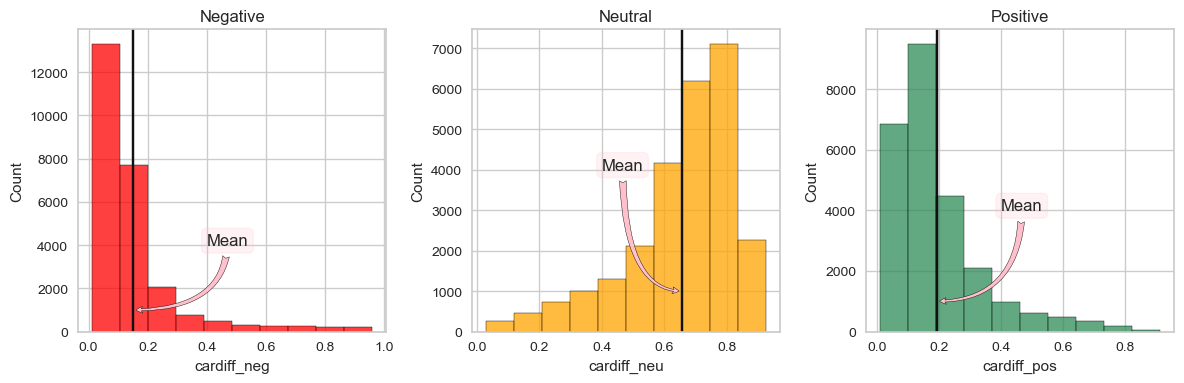

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))
sns.histplot(data=df_all, x='cardiff_neg', bins=10, color='red', ax=axs[0])
sns.histplot(data=df_all, x='cardiff_neu', bins=10, color='orange', ax=axs[1])
sns.histplot(data=df_all, x='cardiff_pos', bins=10, color='seagreen', ax=axs[2])
axs[0].set_title('Negative')
axs[0].axvline(df_all.cardiff_neg.mean(), color='k')
axs[0].annotate(text='Mean', xy=(df_all.cardiff_neg.mean(), 1000), xytext=(0.4, 4000), arrowprops=arrowprops, bbox=bbox)
axs[1].set_title('Neutral')
axs[1].annotate(text='Mean', xy=(df_all.cardiff_neu.mean(), 1000), xytext=(0.4, 4000), arrowprops=arrowprops, bbox=bbox)
axs[1].axvline(df_all.cardiff_neu.mean(), color='k')
axs[2].set_title('Positive')
axs[2].axvline(df_all.cardiff_pos.mean(), color='k')
axs[2].annotate(text='Mean', xy=(df_all.cardiff_pos.mean(), 1000), xytext=(0.4, 4000), arrowprops=arrowprops, bbox=bbox)
plt.tight_layout()
plt.show()

Como se observa en los gráficos, si bien el transformados califica en todos los textos como positivo, neutro o negativo, hay una clara tendencia a clasificar la mayoría de ellos como neutros, posiblemente por la naturaleza de la información (información de stocks de bolsa).